In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

In [2]:
def generar_individuo():
    matriz = np.zeros((8, 8), dtype=int)
    count = 0  
    while count < 8:  
        fila = np.random.randint(0, 8)
        columna = np.random.randint(0, 8)
        if matriz[fila, columna] == 0:  
            matriz[fila, columna] = 1
            count += 1 
    return matriz


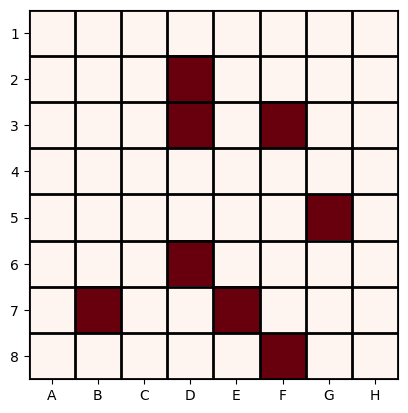

In [3]:
xlabs = ["A", "B", "C", "D", "E", "F", "G", "H"]
ylabs = ["1", "2", "3", "4", "5", "6", "7", "8"]

fig, ax = plt.subplots()
plt.imshow(generar_individuo(), cmap="Reds")

ax.set_xticks(np.arange(-.5, len(xlabs), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(ylabs), 1), minor=True)
ax.set_xticks(np.arange(len(xlabs)), labels=xlabs, minor=False)  
ax.set_yticks(np.arange(len(ylabs)), labels=ylabs, minor=False)  

plt.grid(which="minor", color="black", linestyle='-', linewidth=2)
plt.tick_params(which="minor", size=0)  

plt.show()

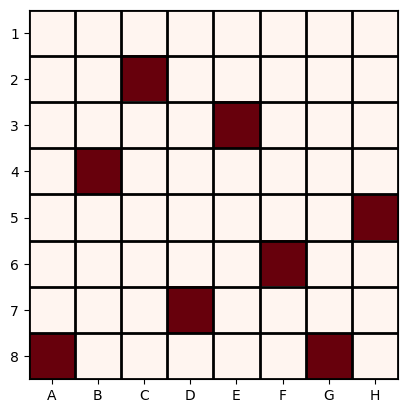

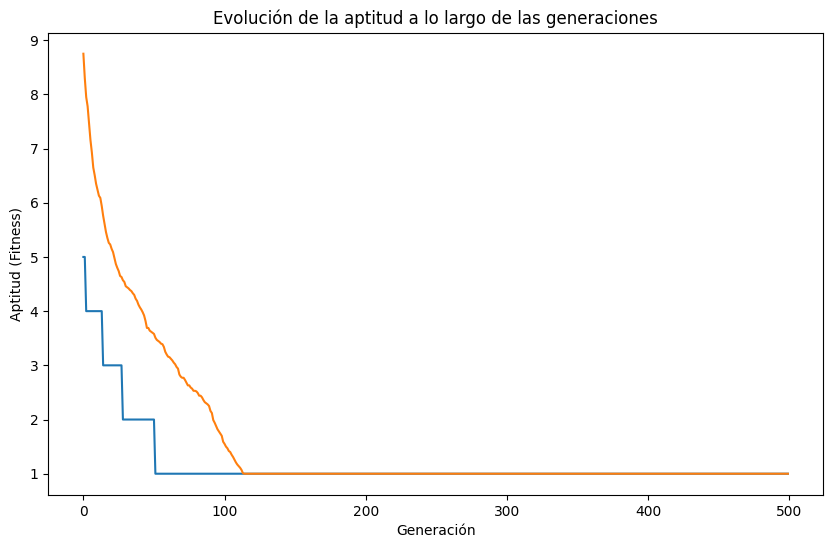

In [4]:
def crear_poblacion_inicial(population_size):
    poblacion = [generar_individuo() for _ in range(population_size)]
    return poblacion

def calcular_aptitud(matriz):
    ataques = 0
    n = matriz.shape[0]  
    # Ataques en filas y columnas
    for i in range(n):
        if np.sum(matriz[i, :]) > 1:  # Más de una reina en la fila
            ataques += np.sum(matriz[i, :]) - 1
        if np.sum(matriz[:, i]) > 1:  # Más de una reina en la columna
            ataques += np.sum(matriz[:, i]) - 1
    # Ataques en diagonales
    for i in range(-n + 1, n):
        diag_principal = np.sum(np.diag(matriz, k=i))
        diag_secundaria = np.sum(np.diag(np.fliplr(matriz), k=i))
        if diag_principal > 1:
            ataques += diag_principal - 1
        if diag_secundaria > 1:
            ataques += diag_secundaria - 1
    return ataques


def evaluar_poblacion(poblacion):
    aptitudes = [calcular_aptitud(individuo) for individuo in poblacion]
    return aptitudes


def seleccionar_padres(poblacion, aptitudes, porcentaje_padres):
    N = int(len(poblacion) * porcentaje_padres)  
    
    indices_ordenados = np.argsort(aptitudes) 
    #indices_ordenados = np.argsort(aptitudes)[::-1]
    poblacion_ordenada = [poblacion[i] for i in indices_ordenados]
    #aptitudes_ordenadas = [aptitudes[i] for i in indices_ordenados]
    
    padres_seleccionados = []
    #aptitudes_seleccionadas = []

    tercio = len(poblacion) // 3  
    for _ in range(N):
        aleatorio = np.random.rand()
        
        if aleatorio < 0.1:
            indice = np.random.randint(2*tercio, len(poblacion))  # último tercio
        elif 0.1 <= aleatorio < 0.4:
            indice = np.random.randint(tercio, 2*tercio)  # segundo tercio
        else:
            indice = np.random.randint(0, tercio)  # primer tercio
        
        padres_seleccionados.append(poblacion_ordenada[indice])
        #aptitudes_seleccionadas.append(aptitudes_ordenadas[indice])
    
    return padres_seleccionados #, aptitudes_seleccionadas

def cruzar_padres(padres_seleccionados):
    padres = padres_seleccionados  
    hijos = []

    for i in range(0, len(padres), 2):
        if i+1 < len(padres):
            padre1 = padres[i]
            padre2 = padres[i+1]
            # Partir los padres por la mitad
            mitad = padre1.shape[1] // 2 
            # Cruzar las mitades
            hijo1 = np.concatenate((padre1[:, :mitad], padre2[:, mitad:]), axis=1)
            hijo2 = np.concatenate((padre2[:, :mitad], padre1[:, mitad:]), axis=1)

            hijos.append(hijo1)
            hijos.append(hijo2)
    return hijos


def reparar_hijo(hijo):
    pos_queens = np.argwhere(hijo == 1).tolist()
    pos_no_queens = np.argwhere(hijo == 0).tolist()
    
    n_queens = len(pos_queens)  
    
    while n_queens != 8:
        if n_queens > 8:
            # Si hay más de 8 reinas, quitar una al azar
            curadito = random.choice(pos_queens)
            pos_queens.remove(curadito)
            hijo[curadito[0]][curadito[1]] = 0
            n_queens -= 1
        else:
            # Si hay menos de 8 reinas, añadir una al azar
            curadito = random.choice(pos_no_queens)
            pos_no_queens.remove(curadito)
            hijo[curadito[0]][curadito[1]] = 1
            pos_queens.append(curadito)
            n_queens += 1
    
    return hijo

def mutar(chromosome):
    pos_queens = np.argwhere(chromosome == 1)  # Encuentra las posiciones de las reinas
    pos_no_queens = np.argwhere(chromosome == 0)  # Encuentra las posiciones sin reinas
    if pos_queens.size == 0 or pos_no_queens.size == 0:
        return chromosome  
    mutated_queen = random.choice(pos_queens)
    mutated_no_queen = random.choice(pos_no_queens)
    chromosome[mutated_queen[0], mutated_queen[1]] = 0
    chromosome[mutated_no_queen[0], mutated_no_queen[1]] = 1
    return chromosome

def sobrevivientes(poblacion, pop_size):
    aptitudes = evaluar_poblacion(poblacion)
    population_with_aptitudes = list(zip(poblacion, aptitudes))
    population_with_aptitudes_sorted = sorted(population_with_aptitudes, key=lambda x: x[1])
    new_population = [individual for individual, aptitude in population_with_aptitudes_sorted]
    new_population = new_population[:pop_size]
    return new_population



def genetico(pop_size, porc_padres, prob_mut, generaciones):
    poblacion = crear_poblacion_inicial(pop_size)
    # print(poblacion)
    mejor_fitness = float('inf')
    historial_fitness = []
    mean_historial = []

    for generacion in range(generaciones):
        fitness = np.array(evaluar_poblacion(poblacion))
        historial_fitness.append(np.min(fitness))
        mean_historial.append(np.mean(fitness))   

        if np.min(fitness) < mejor_fitness:
            mejor_fitness = np.min(fitness)
            #mejor_individuo = poblacion[np.argmin(fitness)] 

        padres =  seleccionar_padres(poblacion, fitness, porc_padres)
        hijos = cruzar_padres(padres)
        hijos_reparados = [reparar_hijo(hijo) for hijo in hijos]
        
        for i in range(len(hijos_reparados)):
            if random.random() < prob_mut:
                hijos_reparados[i] = mutar(hijos_reparados[i])
    
        #poblacion_temporal = np.extend(poblacion, hijos_reparados)   
        poblacion.extend(hijos_reparados)
        poblacion = sobrevivientes(poblacion, pop_size)


    xlabs = ["A", "B", "C", "D", "E", "F", "G", "H"]
    ylabs = ["1", "2", "3", "4", "5", "6", "7", "8"]

    fig, ax = plt.subplots()
    plt.imshow(poblacion[0], cmap="Reds")

    ax.set_xticks(np.arange(-.5, len(xlabs), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(ylabs), 1), minor=True)
    ax.set_xticks(np.arange(len(xlabs)), labels=xlabs, minor=False)  
    ax.set_yticks(np.arange(len(ylabs)), labels=ylabs, minor=False)  

    plt.grid(which="minor", color="black", linestyle='-', linewidth=2)
    plt.tick_params(which="minor", size=0)  

    plt.show()
 

    plt.figure(figsize=(10, 6))
    plt.plot(historial_fitness)
    plt.plot(mean_historial)
    plt.title('Evolución de la aptitud a lo largo de las generaciones')
    plt.xlabel('Generación')
    plt.ylabel('Aptitud (Fitness)')
    plt.show()
#

genetico(pop_size=100, porc_padres=0.2, prob_mut=0.8, generaciones=500)

